We zoeken outliers in de kijkcijfers van het 7-uur journaal op VRT1 en proberen deze te verklaren. 

In [36]:
import numpy as np  
import pandas as pd

In [37]:
kijkcijfers_journaal = pd.read_csv('datasets/kijkcijfers_journaal_7uur.csv', sep=';')
kijkcijfers_journaal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   datum    2878 non-null   object
 1   kijkers  2878 non-null   object
dtypes: object(2)
memory usage: 45.1+ KB


Leidt uit deze data de nodige kolommen af voor het opsporen van outliers. Betrek geen externe data. 

In [38]:
# convert kijkers to int
kijkcijfers_journaal['kijkers'] = kijkcijfers_journaal['kijkers'].str.replace('.', '')
kijkcijfers_journaal['kijkers'] = kijkcijfers_journaal['kijkers'].astype(int)

In [39]:
# convert datum to month
kijkcijfers_journaal['datum'] = pd.to_datetime(kijkcijfers_journaal['datum'])
kijkcijfers_journaal['maand'] = kijkcijfers_journaal['datum'].dt.month
# get day of the week
kijkcijfers_journaal['dag'] = kijkcijfers_journaal['datum'].dt.dayofweek
# drop datum en programma   
kc = kijkcijfers_journaal.drop(['datum'], axis=1)
kc.sample(15)

,kijkers,maand,dag
879,898822,6,2
1882,880556,3,6
438,1012141,3,0
221,724033,8,4
2522,1016757,3,0
1953,754962,6,3
1075,915096,12,4
913,700906,7,1
1277,985633,7,4
2294,769832,7,2


Maak een scatterplot om de correlaties tussen de kolommen te visualiseren. 

array([[<Axes: xlabel='kijkers', ylabel='kijkers'>,
        <Axes: xlabel='maand', ylabel='kijkers'>,
        <Axes: xlabel='dag', ylabel='kijkers'>],
       [<Axes: xlabel='kijkers', ylabel='maand'>,
        <Axes: xlabel='maand', ylabel='maand'>,
        <Axes: xlabel='dag', ylabel='maand'>],
       [<Axes: xlabel='kijkers', ylabel='dag'>,
        <Axes: xlabel='maand', ylabel='dag'>,
        <Axes: xlabel='dag', ylabel='dag'>]], dtype=object)

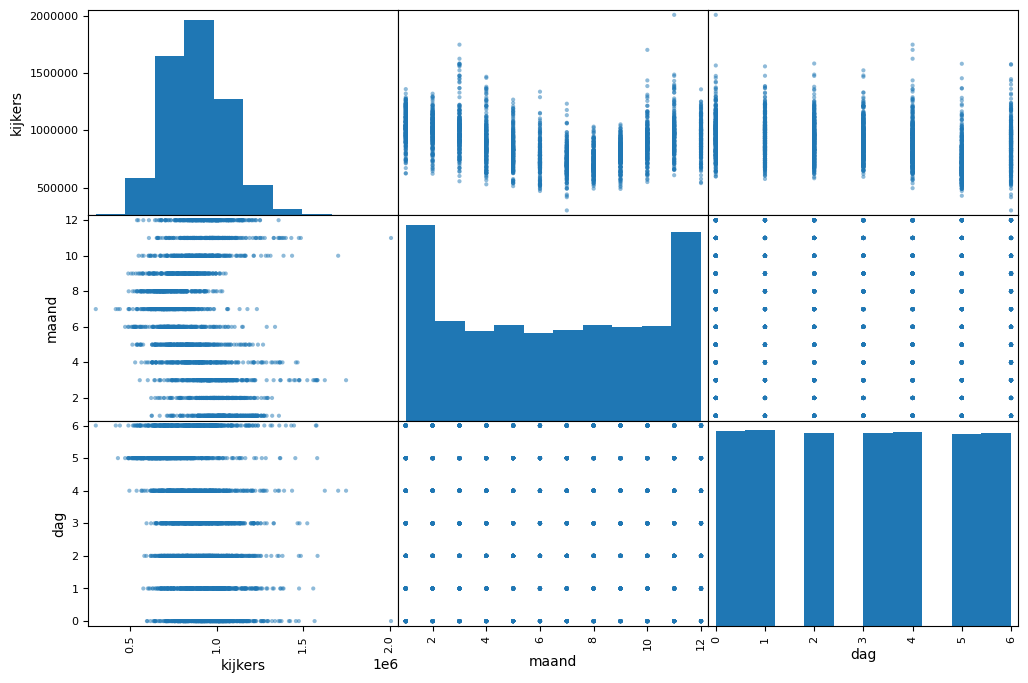

In [40]:
from pandas.plotting import scatter_matrix
scatter_matrix(kc, figsize=(12, 8))

Maak een clustering van de data met Gaussian Mixture. Kies een "beredeneerd" aantal clusters. 

In [41]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=7, n_init=10, random_state=42)
gm.fit(kc)

GaussianMixture(n_components=7, n_init=10, random_state=42)

Convergeert het algoritme? 

In [42]:
gm.converged_

True

Selecteer de 10 grootste outliers (op basis van de density score) en koppel ze terug aan de oorspronkelijke data. 


In [43]:
pct = (10 / len(kc) ) * 100

In [44]:
densities = gm.score_samples(kc)
kc['density'] = densities
print(densities)
density_threshold = np.percentile(densities, pct)
print(density_threshold)
anomalies = kc[densities < density_threshold]



[-11.85931559 -12.42225338 -11.79486579 ... -17.56471401 -16.81544451
 -16.59443116]
-22.849424120436


In [45]:
# order by density
anomalies = anomalies.sort_values(by='density', ascending=True)
anomalies

,kijkers,maand,dag,density
1406,2008425,11,0,-29.217971
557,301836,7,6,-24.704818
86,602433,3,1,-23.572553
2807,576659,12,1,-23.482532
1375,1702882,10,4,-23.425996
717,643979,12,0,-23.383224
1378,1475575,11,0,-23.198411
2800,608937,12,1,-23.139454
1377,1432159,11,6,-22.992969
1173,1748530,3,4,-22.852089


<Axes: >

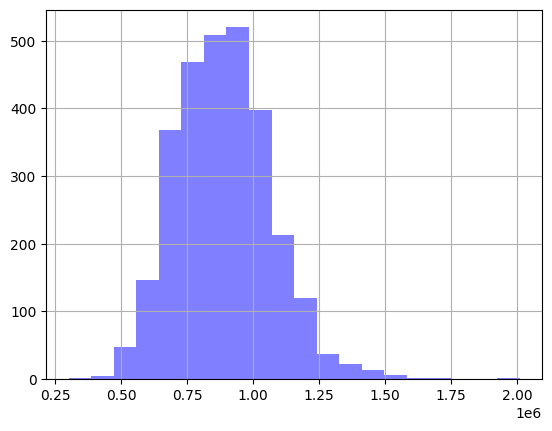

In [46]:
kc['kijkers'].hist(bins=20, alpha=0.5, color='blue')

In [33]:
# koppel de anomalien aan de originele data m.b.v. de index
anomalies = kijkcijfers_journaal[kijkcijfers_journaal.index.isin(anomalies.index)]


In [34]:
anomalies

,datum,kijkers,maand,dag
86,2017-03-28,602433,3,1
557,2018-07-15,301836,7,6
717,2018-12-24,643979,12,0
1173,2020-03-27,1748530,3,4
1375,2020-10-30,1702882,10,4
1377,2020-11-01,1432159,11,6
1378,2020-11-02,1475575,11,0
1406,2020-11-30,2008425,11,0
2800,2024-12-24,608937,12,1
2807,2024-12-31,576659,12,1


Zoek op het internet de nieuwsuitzending die als grootste outlier wordt beschouwd. Kun je dit uitzonderlijk hoge aantal verklaren of betreft het hier een registratie-fout? 

--> Heropening winkels en afscheid Martine Tanghe --> geen registratiefout

Zou het model beter kunnen worden door eerste de meest extreme outliers te verwijderen? 

--> Ja, want de gebeurtenissen die de extremen verklaren zit niet als feature in het model en kunnen dus nooit voorspeld worden. 